In [1]:
import numpy as np
import matplotlib.pyplot as plt


### 1. 圖像分割（ Image Segmentation ）

In [2]:
from sklearn.datasets import load_sample_images

dataset = load_sample_images()
Img = dataset.images[1]
Img.shape

(427, 640, 3)

<function matplotlib.pyplot.show(close=None, block=None)>

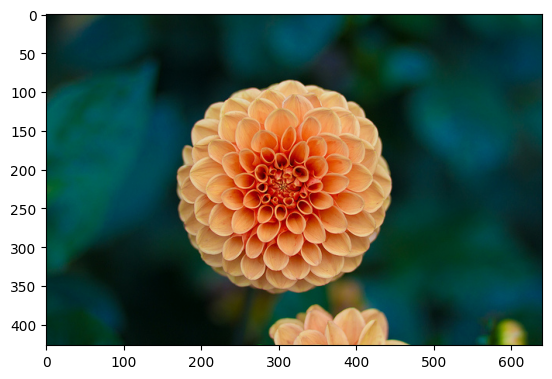

In [3]:
img = Img/255
plt.imshow(img)
plt.show

In [4]:
x = img.reshape(-1,3)
x.shape

(273280, 3)

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(x)

In [6]:
kmeans.cluster_centers_, kmeans.labels_

(array([[0.02532874, 0.21206492, 0.19542382],
        [0.82560911, 0.53271071, 0.31326013]]),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int32))

In [7]:
seg_img = kmeans.cluster_centers_[kmeans.labels_]
seg_img

array([[0.02532874, 0.21206492, 0.19542382],
       [0.02532874, 0.21206492, 0.19542382],
       [0.02532874, 0.21206492, 0.19542382],
       ...,
       [0.02532874, 0.21206492, 0.19542382],
       [0.02532874, 0.21206492, 0.19542382],
       [0.02532874, 0.21206492, 0.19542382]])

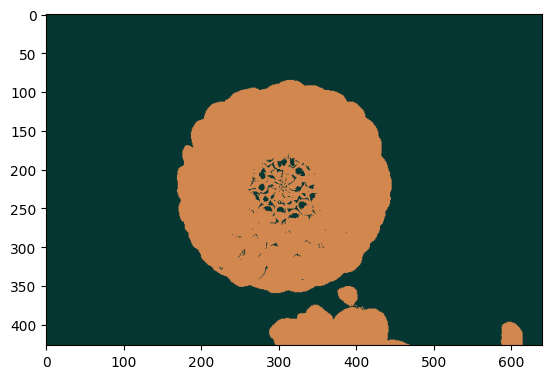

In [8]:
seg_img = seg_img.reshape(img.shape)
plt.imshow(seg_img)
plt.show()

### 2. 資料預處理 (Data Preprocessing)

In [9]:
from sklearn.datasets import load_digits

x, y = load_digits(return_X_y=True)
x.shape, y.shape

((1797, 64), (1797,))

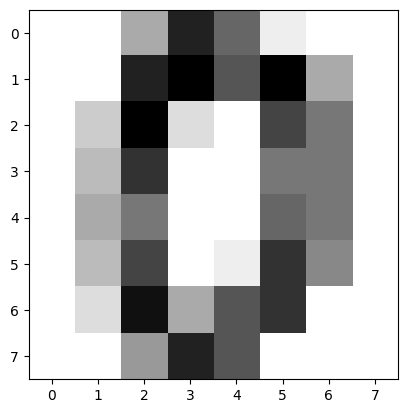

In [10]:
i = 0

xi = x[i].reshape(8,8)
plt.imshow(xi, cmap='binary')
plt.show()


In [11]:
y[i]

0

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size=0.2)

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='ovr', max_iter=5000)

log_reg.fit(x_train, y_train)
log_reg.score(x_test, y_test)

0.9722222222222222

In [15]:
kmeans = KMeans(n_clusters=40)

x_train_dist = kmeans.fit_transform(x_train, y_train)

x_train_dist.shape

(1437, 40)

In [16]:
log_reg = LogisticRegression(multi_class='ovr', max_iter=5000)

log_reg.fit(x_train_dist, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [17]:
x_test_dist = kmeans.transform(x_test)
log_reg.score(x_test_dist, y_test)

0.9777777777777777

In [18]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=40)),
    ('log_reg', LogisticRegression(multi_class='ovr', max_iter=5000))
])

pipeline.fit(x_train, y_train)
pipeline.score(x_test, y_test)

0.975

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=np.linspace(2, 100, 10).astype(int))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.1s
[CV] END ..............................kmeans__n_clusters=12; total time=   0.7s
[CV] END ..............................kmeans__n_clusters=12; total time=   1.1s
[CV] END ..............................kmeans__n_clusters=12; total time=   0.6s
[CV] END ..............................kmeans__n_clusters=23; total time=   2.7s
[CV] END ..............................kmeans__n_clusters=23; total time=   2.2s
[CV] END ..............................kmeans__n_clusters=23; total time=   2.3s
[CV] END ..............................kmeans__n_clusters=34; total time=   1.7s
[CV] END ..............................kmeans__n_clusters=34; total time=   2.1s
[CV] END ..............................kmeans__n

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=40)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr'))]),
             param_grid={'kmeans__n_clusters': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
             verbose=2)

In [20]:
grid_clf.best_params_

{'kmeans__n_clusters': 100}

In [21]:
result = grid_clf.cv_results_

for mean_score, params in zip(result['mean_test_score'], result['params']):
    print(mean_score, params)

0.3472512178148921 {'kmeans__n_clusters': 2}
0.941544885177453 {'kmeans__n_clusters': 12}
0.9561586638830898 {'kmeans__n_clusters': 23}
0.965205288796103 {'kmeans__n_clusters': 34}
0.9700765483646486 {'kmeans__n_clusters': 45}
0.9728601252609604 {'kmeans__n_clusters': 56}
0.9707724425887266 {'kmeans__n_clusters': 67}
0.9686847599164926 {'kmeans__n_clusters': 78}
0.9679888656924147 {'kmeans__n_clusters': 89}
0.9735560194850382 {'kmeans__n_clusters': 100}


In [22]:
grid_clf.best_estimator_.score(x_test, y_test)

0.9833333333333333

### 3. 半監督式學習（ Semi-supervised Learning）

In [23]:
k = 50

kmeans = KMeans(n_clusters=k)
x_dist = kmeans.fit_transform(x_train)

In [24]:
rep_ind = np.argmin(x_dist, axis=0)
x_train_rep = x_train[rep_ind]

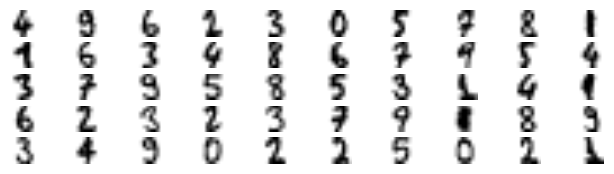

In [25]:
plt.figure(figsize=(8,2))

for idx, xi in enumerate(x_train_rep):
    plt.subplot(k//10, 10, idx+1)
    plt.imshow(xi.reshape(8,8), cmap='binary', interpolation='bilinear')
    plt.axis('off')

plt.show()

In [26]:
y_rep = np.array([
  9, 2, 0, 4, 7, 5, 1, 6, 3, 1,
  2, 3, 1, 6, 8, 5, 2, 9, 4, 4,
  7, 4, 8, 3, 6, 9, 5, 7, 7, 2,
  2, 1, 4, 7, 3, 0, 9, 4, 7, 3,
  1, 1, 3, 1, 0, 2, 8, 9, 8, 4
])

In [27]:
y_train_propagated = np.empty(len(x_train), dtype=np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_rep[i]

In [28]:
x_train.shape, y_train_propagated.shape

((1437, 64), (1437,))

In [29]:
log_reg = LogisticRegression(multi_class='ovr', max_iter=5000)

log_reg.fit(x_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr')

In [30]:
log_reg.score(x_test, y_test)

0.10277777777777777